In [1]:
import pandas as pd
import numpy as np

# show all df columns
pd.set_option('display.max_columns', None)

# Helps to reload .py functions when edited
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.metrics import r2_score

# Define scoring metric
def rmse(y_actual, y_predicted):
    return np.sqrt(np.mean(np.square(y_actual - y_predicted)))

def print_score(m):
    y_bar = m.predict(X)
    res = [rmse(y_bar, y), r2_score(y_bar.reshape(-1,1), y.values.reshape(-1,1))]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [14]:
train_df = pd.read_pickle("tf_data/train_df.pkl")
test_df = pd.read_pickle("tf_data/test_df.pkl")
target_df = pd.read_pickle("tf_data/target_df.pkl")
target_df = target_df.apply(lambda x: np.log(x))

In [4]:
train_df.shape, test_df.shape

((175000, 591), (83210, 591))

In [5]:
test_df.head()

,designation,province,region_1,region_2,taster_name,title,variety_col,winery_col,ratings,country_region,has_twit_handle,title_year,no_of_words,designation_province,designation_region_1,designation_region_2,designation_taster_name,designation_title,designation_variety,designation_winery,designation_ratings,designation_country_region,designation_has_twit_handle,designation_title_year,designation_no_of_words,province_region_1,province_region_2,province_taster_name,province_title,province_variety,province_winery,province_ratings,province_country_region,province_has_twit_handle,province_title_year,province_no_of_words,region_1_region_2,region_1_taster_name,region_1_title,region_1_variety,region_1_winery,region_1_ratings,region_1_country_region,region_1_has_twit_handle,region_1_title_year,region_1_no_of_words,region_2_taster_name,region_2_title,region_2_variety,region_2_winery,region_2_ratings,region_2_country_region,region_2_has_twit_handle,region_2_title_year,region_2_no_of_words,taster_name_title,taster_name_variety,taster_name_winery,taster_name_ratings,taster_name_country_region,taster_name_has_twit_handle,taster_name_title_year,taster_name_no_of_words,title_variety,title_winery,title_ratings,title_country_region,title_has_twit_handle,title_title_year,title_no_of_words,variety_winery,variety_ratings,variety_country_region,variety_has_twit_handle,variety_title_year,variety_no_of_words,winery_ratings,winery_country_region,winery_has_twit_handle,winery_title_year,winery_no_of_words,ratings_country_region,ratings_has_twit_handle,ratings_title_year,ratings_no_of_words,country_region_has_twit_handle,country_region_title_year,country_region_no_of_words,has_twit_handle_title_year,has_twit_handle_no_of_words,title_year_no_of_words,accented,accents,acid,acidic,acidity,acids,add,adds,aftertaste,age,aged,aging,alcohol,almond,almost,along,alongside,already,also,although,anise,another,appealing,apple,apples,apricot,aroma,aromas,aromas flavors,aromatic,around,astringent,attractive,back,backed,bacon,baked,baking,balance,balanced,barrel,based,beautiful,beautifully,beef,berries,berry,berry aromas,berry flavors,berry fruit,berry fruits,best,better,big,bit,bitter,black,black cherry,black currant,black fruit,black fruits,black pepper,black plum,blackberries,blackberry,blackberry cherry,blanc,blend,blossom,blue,blueberry,bodied,bodied wine,body,bold,bone,bordeaux,bottle,bottling,bouquet,bright,bright acidity,brings,brisk,buttered,cab,cabernet,cabernet franc,cabernet sauvignon,california,candied,candy,caramel,cassis,cedar,cellar,character,chardonnay,cherries,cherry,cherry flavors,cherry fruit,cherry raspberry,chewy,chocolate,chunky,cinnamon,citrus,citrusy,classic,clean,close,clove,cocoa,coffee,cola,color,come,comes,complex,complexity,concentrated,concentration,cool,core,could,cranberry,cream,creamy,crisp,crisp acidity,crushed,currant,currants,cut,dark,dark chocolate,deep,delicate,delicious,delivers,dense,depth,despite,develop,dried,drink,drink now–,drinking,driven,dry,dusty,earth,earthy,easy,edge,elegance,elegant,end,enjoy,enough,espresso,estate,even,excellent,exotic,expression,fairly,feel,feels,fermented,find,fine,finish,finish drink,finishes,finishing,firm,firm tannins,first,flavor,flavored,flavors,flavors finish,floral,flower,flowers,followed,food,forest,forward,fragrant,franc,french,french oak,fresh,fresh acidity,freshness,friendly,front,fruit,fruit aromas,fruit flavors,fruitiness,fruits,fruity,fruity wine,full,full bodied,generous,get,give,gives,giving,glass,good,grape,grapefruit,grapes,great,green,green apple,grenache,grilled,grown,hard,heat,heavy,herb,herbal,herbs,high,hint,hints,honey,honeysuckle,hot,imported,impressive,integrated,intense,intensity,interesting,jam,jammy,juice,juicy,layered,layers,lead,leaf,lean,least,leather,lemon,length,licorice,light,lightly,like,lime,lingering,little,lively,long,long finish,lot,lots,lovely,low,lush,made,make,makes,making,malbec,many,mature,may,meat,meaty,medium,medium bodied,melon,merlot,midpalate,mild,min

In [6]:
#Import libraries:
#Import libraries:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV #Perforing grid search
from sklearn import metrics   #metrics

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

SEED = 27
X = train_df.copy()
X_test = test_df.copy()
y = target_df
predictors = train_df.columns

In [7]:
def modelfit(alg, predictors, X_train=X, y_train=y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='rmse', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
        
        print("n_estimators: ", cvresult.shape[0])
    # Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='rmse')

    # Predict training set:
    Xtrain_predictions = alg.predict(X_train)
    
    # Print model report:
    print("\nModel Report")
    print("R2 Score : %.4g" % metrics.r2_score(
                                                y_train.values, Xtrain_predictions))
    rmse = 2*np.sqrt(metrics.mean_squared_error(y_train, Xtrain_predictions))
    print("RMSE Score (Train): %f" % rmse)
    
    print(cvresult.tail())
    
    xgb.plot_importance(alg, max_num_features=20, height=0.8)

### Base Model

n_estimators:  400


/home/aims/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/aims/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Model Report
R2 Score : 0.98
RMSE Score (Train): 10.851456
     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
395         5.191694        0.052279       16.697524       3.140567
396         5.186028        0.053647       16.697326       3.141557
397         5.180039        0.051718       16.696596       3.141784
398         5.173495        0.050798       16.696086       3.142400
399         5.170630        0.050204       16.695965       3.142450


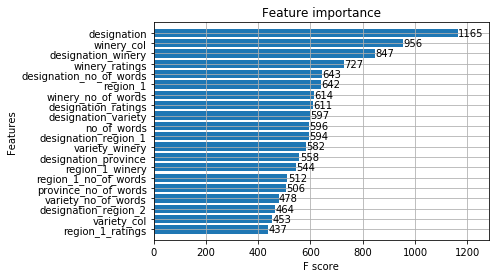

In [8]:
xgb0 = XGBRegressor(
    learning_rate=0.2,
    n_estimators=72,
    max_depth=9,
    min_child_weight=3,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1,
    scale_pos_weight=1,
    silent=True,
    seed=SEED)
modelfit(xgb0, predictors=predictors)

n_estimators:  72


/home/aims/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/aims/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Model Report
R2 Score : 0.9468
RMSE Score (Train): 17.716517
    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
67         8.901314        0.182678       17.168050       3.077870
68         8.871736        0.189050       17.165970       3.074322
69         8.851842        0.188699       17.159072       3.077570
70         8.821077        0.195228       17.150176       3.080984
71         8.798278        0.191893       17.146833       3.083757


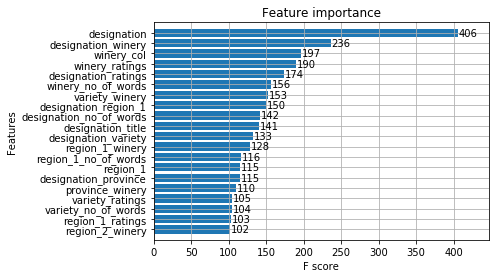

In [16]:
xgb1 = XGBRegressor(
    learning_rate=0.2,
    n_estimators=72,
    max_depth=9,
    min_child_weight=3,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1,
    scale_pos_weight=1,
    silent=True,
    seed=SEED)
modelfit(xgb1, predictors=predictors)

In [26]:
def grid_details(grid_search):
    grid_search.fit(X,y)
    print(f'Best Params: {np.sqrt(-1*grid_search.best_score_)}, {grid_search.best_params_}\n'
          )
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)

In [27]:
param_test1 = {
    'max_depth': range(2, 10, 1),
    'min_child_weight': range(1, 6, 2)
}
gsearch1 = GridSearchCV(estimator=XGBRegressor(learning_rate=0.2, n_estimators=72, max_depth=5,
                                               min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                               objective='reg:linear', nthread=4, scale_pos_weight=1, seed=SEED),
                        param_grid=param_test1, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)

grid_details(gsearch1)

/home/aims/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/aims/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:32:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Params: 0.22286798079131476, {'max_depth': 9, 'min_child_weight': 3}

0.2702126553897653 {'max_depth': 2, 'min_child_weight': 1}
0.270212846752687 {'max_depth': 2, 'min_child_weight': 3}
0.27035042285125127 {'max_depth': 2, 'min_child_weight': 5}
0.259250518180303 {'max_depth': 3, 'min_child_weight': 1}
0.25924037434402253 {'max_depth': 3, 'min_child_weight': 3}
0.25908258748616997 {'max_depth': 3, 'min_child_weight': 5}
0.24945615202759366 {'max_depth': 4, 'min_child_weight': 1}
0.24979387758885263 {'max_depth': 4, 'min_child_weight': 3}
0.24964477588070003 {'max_depth': 4, 'min_child_weight': 5}
0.24250627873117 {'max_depth': 5, 'min_child_weight': 1}
0.24216739607818966 {'max_depth': 5, 'min_child_weight': 3}
0.2423307085558187 {'max_depth': 5, 'min_child_weight': 5}
0.23642552741634232 {'max_depth': 6, 'min_child_weight': 1}
0.23634541109690052 {'max_d

Tune gamma

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator=XGBRegressor(learning_rate=0.2, n_estimators=100, max_depth=9,
                                               min_child_weight=3, subsample=0.8, colsample_bytree=0.8,
                                               objective='reg:linear', nthread=4, scale_pos_weight=1, 
                                               seed=SEED),
                        param_grid=param_test3, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)

grid_details(gsearch3)

n_estimators:  400


/home/aims/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/aims/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Model Report
R2 Score : 0.97
RMSE Score (Train): 0.229029
     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
395         0.105508        0.000460        0.206807       0.001707
396         0.105334        0.000455        0.206799       0.001704
397         0.105160        0.000474        0.206774       0.001716
398         0.105074        0.000504        0.206760       0.001717
399         0.104901        0.000501        0.206735       0.001708


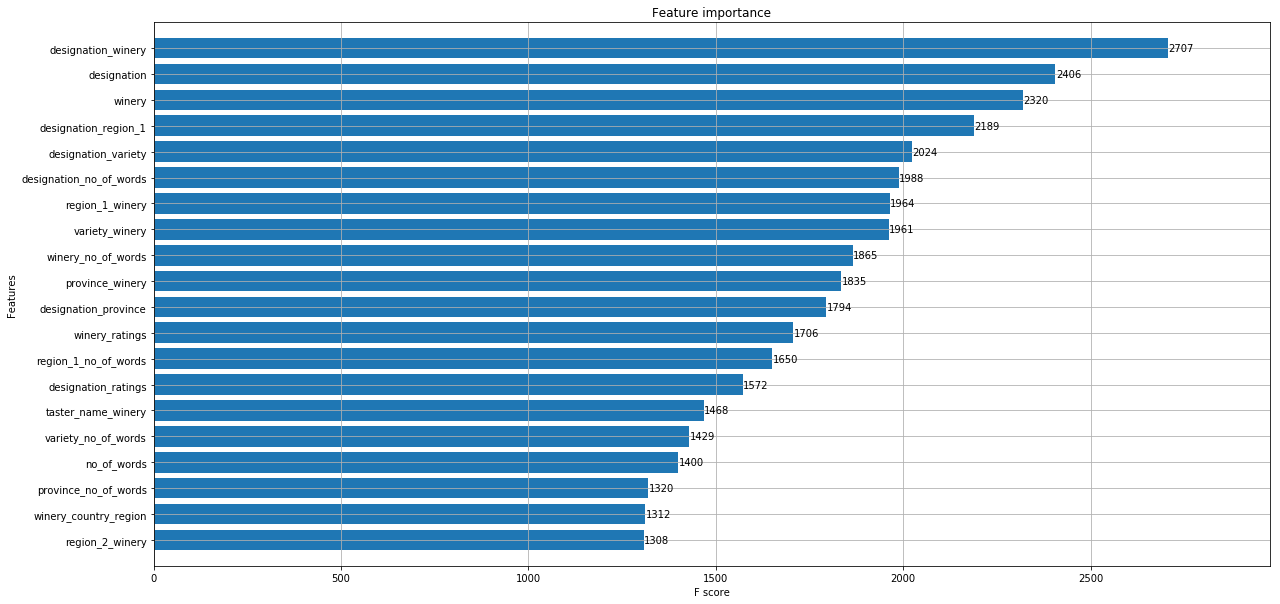

In [29]:
xgb1 = XGBRegressor(
    learning_rate=0.1/,
    n_estimators=400,
    max_depth=9,
    min_child_weight=3,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1,
    scale_pos_weight=1,
    silent=True,
    seed=SEED)
modelfit(xgb1, predictors=predictors)

n_estimators:  288


/home/aims/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/aims/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Model Report
R2 Score : 0.8507
RMSE Score (Train): 0.510739
     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
283         0.255603        0.000519        0.257863       0.001702
284         0.255549        0.000517        0.257812       0.001693
285         0.255495        0.000531        0.257760       0.001682
286         0.255453        0.000518        0.257727       0.001683
287         0.255411        0.000525        0.257691       0.001679


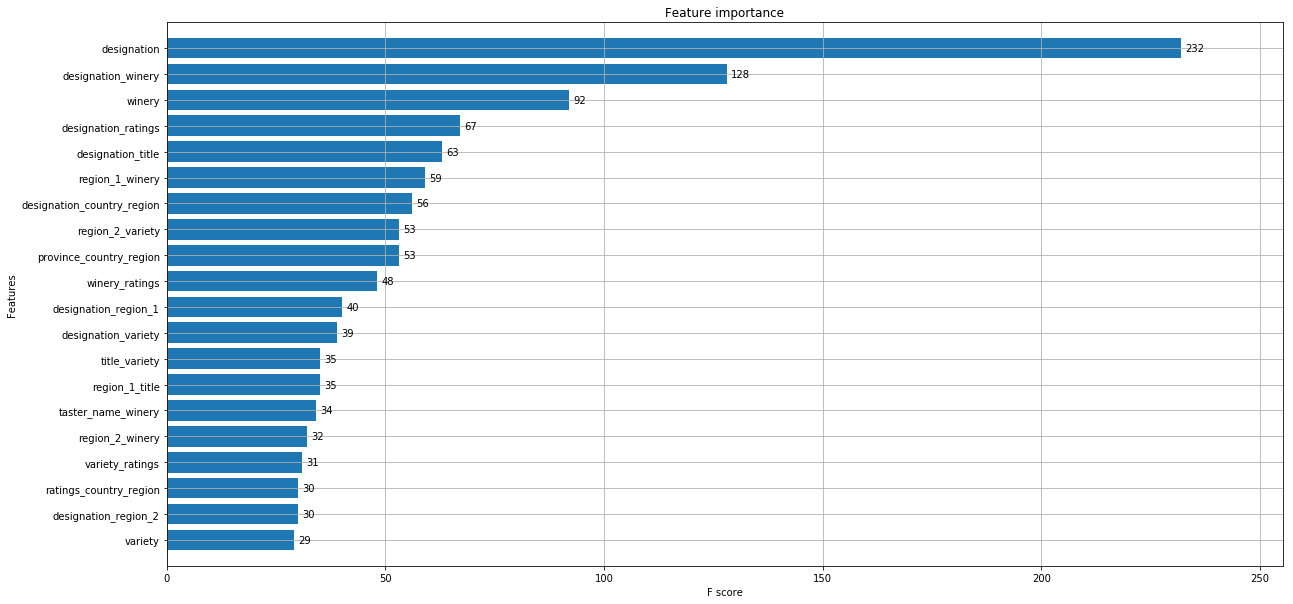

In [34]:
#Reduce lr by half and increase trees by 2
xgb2 = XGBRegressor(
    learning_rate=0.1/2,
    n_estimators=144*2,
    max_depth=3,
    min_child_weight=3,
    gamma=0,
    subsample=0.7,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    scale_pos_weight=1,
    reg_alpha=1e-05,
    seed=SEED)
modelfit(xgb2, predictors)

In [ ]:
### Submision

In [11]:
test_label = xgb0.predict(X_test)

In [12]:
test_label[0:10]

array([89.27963 , 37.833767, 49.207256, 31.914106, 16.402199, 17.74326 ,
       10.264553,  9.563859, 13.280017, 54.934864], dtype=float32)

In [13]:
# Submissions to kaggle
from submission1 import submit
submit(test_label, test_df)

Fist 10 predictions: [89.27963  37.833767 49.207256 31.914106 16.402199 17.74326  10.264553
  9.563859 13.280017 54.934864]

Save path : submissions/submission_xgb2.csv


Ensemble

In [2]:
import pandas as pd
import numpy as np

In [7]:
rf = pd.read_csv('ens/submission_rf1.csv', index_col='id' )

In [8]:
xg1 = pd.read_csv('ens/submission_xgb1.csv',index_col='id')

In [9]:
xg2 = pd.read_csv('ens/submission_xgb1.csv',  index_col='id')

In [15]:
submission_ens1 = 0.2*rf+0.4*xg1+0.4*xg2

In [16]:
submission_ens1

,price
id,
0,92.168189
1,37.190991
2,58.191925
3,29.421452
4,14.428698
...,...
83205,14.799865
83206,36.951052
83207,37.560643


In [20]:
submission_ens1.to_csv('submission_ens.csv')